# Data Overview
**Authors :**
   * _Louis Lacroix_
   * _Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [1]:
import os
import gc
import datetime
import random

import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
from PIL import ImageDraw, ImageFont
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader as TorchDataLoader, random_split
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from data_manager.datamanager import DataLoader, DataDisplayer, DataTransformer
from models.model import Unet

In [2]:
# Execution parameters
LIBERATE_MEMORY = True # Delete intermediate object to free memory space
GPU = 0

# Run of the notebook
TRAIN_MODEL = False
SAVE_MODEL = True
SAVE_INTERMEDIATE_MODELS = (True, 20)
LOAD_MODEL = True
assert LOAD_MODEL != TRAIN_MODEL, f"Either specify a LOAD or SAVE status for the model, not both"
MODEL_LOAD_PATH = "models/trained_models/2024-12-16-14-06_4-channels_{}-unet.pt"
PARAMS_LOAD_PATH = "models/parameters/2024-12-16-14-06_4-channels_params.txt"

# Parameters to use for the model
IMAGE_SIZE = 128
MULTI_CHANNEL = True
BATCH_SIZE = 16
EPOCHS = 100
T = 1000
DIM_MULTS = (1, 2, 4, 8)

In [3]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [ ]:
current_datetime = datetime.datetime.now() 
SAVE_PATH = f"images/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + '4-channels' if MULTI_CHANNEL else '1-channel'
MODEL_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_trained-unet.pt"
MODEL_BEST_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_best-trained-unet.pt"
MODEL_INTERMEDIATE_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_epoch-{}-unet.pt"

PARAMS_SAVE_PATH = f"models/parameters/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_params.txt"

INPUT_SAVE_PATH = SAVE_PATH + "_batch_input.jpg"
OUTPUT_LOSS_MONITORING_PATH = SAVE_PATH + "_loss_monitoring.jpg"
OUTPUT_LOSS_MONITORING_LOG_PATH = SAVE_PATH + "_loss_monitoring_log.jpg"
OUTPUT_SAVE_PATH = SAVE_PATH + "_sampling.jpg"
OUTPUT_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.jpg"
OUTPUT_GIF_SAVE_PATH = SAVE_PATH + "_sampling.gif.png"
OUTPUT_GIF_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.gif.png"

In [ ]:
if LOAD_MODEL:
    # Initialize an empty dictionary to hold the loaded parameters
    loaded_params = {}

    # Load parameters from the file
    with open(PARAMS_LOAD_PATH, "r") as file:
        for line in file:
            # Strip any whitespace and split key-value pairs
            key, value = line.strip().split(" = ")
            # Convert the value back to its original type (e.g., int, float, list, etc.)
            try:
                loaded_params[key] = eval(value)
            except:
                loaded_params[key] = value

    # Assign loaded parameters back to your variables
    IMAGE_SIZE = loaded_params.get("IMAGE_SIZE")
    MULTI_CHANNEL = loaded_params.get("MULTI_CHANNEL")
    BATCH_SIZE = loaded_params.get("BATCH_SIZE")
    EPOCHS = loaded_params.get("EPOCHS")
    T = loaded_params.get("T")
    DIM_MULTS = loaded_params.get("DIM_MULTS")

    print(f"Parameters loaded from '{PARAMS_LOAD_PATH}'\n")

    # Display loaded parameters
    print("Loaded Parameters:")
    for key, value in loaded_params.items():
        print(f"- {key}: {value} {type(value)}")

In [ ]:
# Write parameters to the file
SAVE_PARAMS = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "MULTI_CHANNEL": MULTI_CHANNEL,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "T": T,
    "DIM_MULTS": DIM_MULTS
}
with open(PARAMS_SAVE_PATH, "w") as file:
    for key, value in SAVE_PARAMS.items():
        file.write(f"{key} = {value}\n")
print(f"Parameters saved to '{PARAMS_SAVE_PATH}'")

In [4]:
# Define the root data folder
root_data_folder = os.path.join(os.path.dirname(os.getcwd()), 'database')

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

## II. Data Loading and Displaying

In [5]:
# Create a DataLoader instance
data_loader = DataLoader(root_data_folder)

# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True)


Loading data in 'C:\Users\benji\Documents\Git-repositories\Telecom-Paris\3A\PRIM-AI-Diffusion-Models-for-Cardi…

Loading data in 'C:\Users\benji\Documents\Git-repositories\Telecom-Paris\3A\PRIM-AI-Diffusion-Models-for-Cardi…

In [6]:
# Initialize the DataDisplayer with the DataLoader instance
data_displayer = DataDisplayer(data_loader, group_map=group_map)

data_loader.data
├── train
│	├── patient001
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient002
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
├── test
│	├── patient101
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient102
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient117, height: 180.0cm, weight: 92.0kg, group: DCM, nb_frames: 30


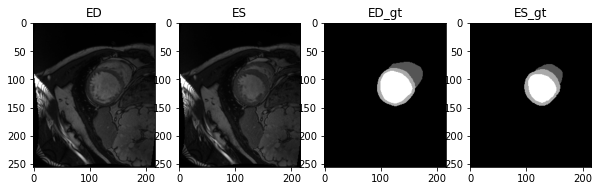

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient105, height: 173.0cm, weight: 84.0kg, group: HCM, nb_frames: 30


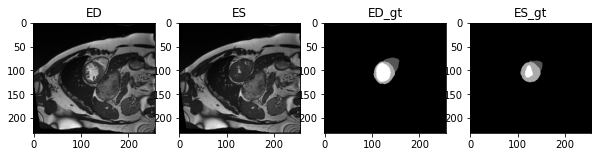

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient148, height: 170.0cm, weight: 70.0kg, group: MINF, nb_frames: 35


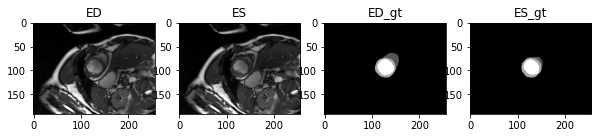

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient107, height: 155.0cm, weight: 47.0kg, group: NOR, nb_frames: 30


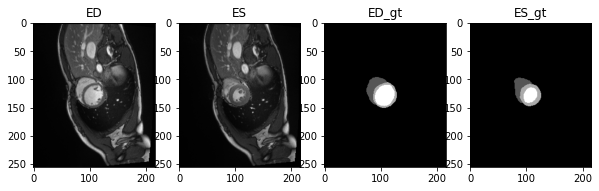

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient124, height: 174.0cm, weight: 64.0kg, group: RV, nb_frames: 15


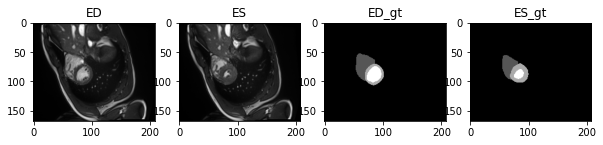

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient004, height: 159.0cm, weight: 46.0kg, group: DCM, nb_frames: 28


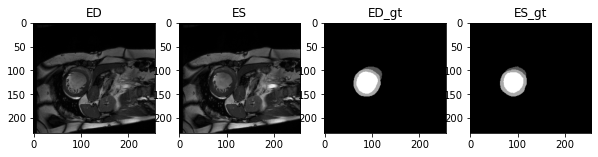

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient025, height: 174.0cm, weight: 82.0kg, group: HCM, nb_frames: 25


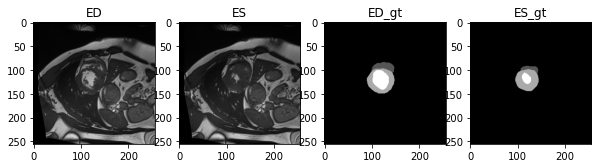

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient058, height: 168.0cm, weight: 68.0kg, group: MINF, nb_frames: 30


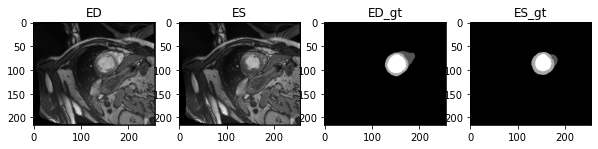

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient077, height: 180.0cm, weight: 75.0kg, group: NOR, nb_frames: 25


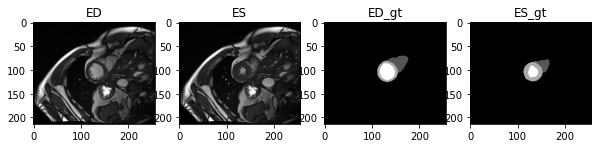

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient096, height: 186.0cm, weight: 76.0kg, group: RV, nb_frames: 15


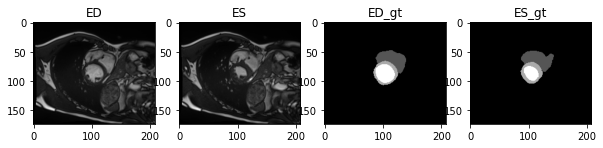

In [7]:
# Display as an arborescence the dataloader.data dictionary
print(data_displayer.display_data_arborescence('data_loader.data', max_keys={1: 2}))

# Display some examples
data_displayer.display_examples(nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## III. Data Overview

There are 74 different shapes in the data
X axis varies from 154 to 428
Y axis varies from 154 to 512
Z axis varies from 6 to 21
Aspect ratio (X/Y) varies from 0.6388888888888888 to 1.4545454545454546


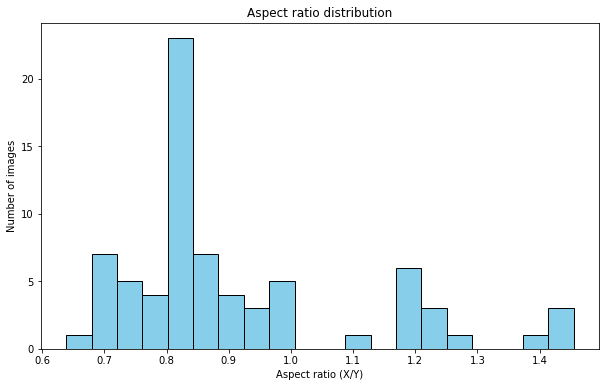

In [8]:
# Show repartition of shape of the images
shape_dict = {}
for dataset_key, dataset in data_loader.data.items():
    for patient, patient_data in dataset.items():
        for image_name, image in patient_data['image_data'].items():
            shape = image.shape
            if shape not in shape_dict:
                shape_dict[shape] = 1
            else:
                shape_dict[shape] += 1

print(
    f'There are {len(shape_dict)} different shapes in the data'
    f'\nX axis varies from {min([shape[0] for shape in shape_dict.keys()])} to {max([shape[0] for shape in shape_dict.keys()])}'
    f'\nY axis varies from {min([shape[1] for shape in shape_dict.keys()])} to {max([shape[1] for shape in shape_dict.keys()])}'
    f'\nZ axis varies from {min([shape[2] for shape in shape_dict.keys()])} to {max([shape[2] for shape in shape_dict.keys()])}'
    f'\nAspect ratio (X/Y) varies from {min([shape[0] / shape[1] for shape in shape_dict.keys()])} to {max([shape[0] / shape[1] for shape in shape_dict.keys()])}'
)
# plot the repartition of the aspect ratio
plt.figure(figsize=(10, 6))
plt.hist([shape[0] / shape[1] for shape in shape_dict.keys()], bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect ratio distribution')
plt.xlabel('Aspect ratio (X/Y)')
plt.ylabel('Number of images')
plt.show()

## IV. Preprocessing

In [9]:
# Instanciate the data transformer
data_transformer = DataTransformer(data_loader)

In [10]:
# Resize the images to a common shape
target_shape = (IMAGE_SIZE, IMAGE_SIZE)
data_transformer.crop_and_resize(target_shape=target_shape, padding=0.2, output_key='image_resized_data', keep_3d_consistency=False, link_gt_to_data=False, create_channels_from_gt=MULTI_CHANNEL, image_names=['ED_gt', 'ES_gt'])

# Display tree of the data after resizing
print(data_displayer.display_data_arborescence('data_loader.data', max_keys=7))

Transforming images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Transforming images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

data_loader.data
├── train
│	├── patient001
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient002
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient003
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient004
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient005
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	

In [ ]:
# Display some examples for the resized images
data_displayer.display_examples(image_type='image_resized_data', image_names=['ED_gt', 'ES_gt'], nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## V. Data Augmentation

In [ ]:
transformed_images_gt = data_loader.extract_specific_images(image_types=['image_resized_data'], image_names=['ED_gt', 'ES_gt'])
rotated_images = []
nb_rotations = 7
max_angle = 45
for angle in tqdm(np.linspace(-max_angle, max_angle, nb_rotations), desc='Rotating images'):
    if angle == 0:
        rotated_images.append(transformed_images_gt)
    else:
        rotated_images.append(DataTransformer.rotate_images(angle=angle, images=transformed_images_gt, has_channels=transformed_images_gt[0].shape[0] > 3))
# concatenate all lists
rotated_images = [images for sublist in rotated_images for images in sublist]
print(f'Number of images after rotation: {len(rotated_images)}')

## Model Diffusion Process

In [ ]:
DEVICE = torch.device(f"cuda:{GPU}") if torch.cuda.is_available() else "cpu"

## Preprocessing

In [ ]:
# Dataset parameters
batch_size = BATCH_SIZE

In [ ]:
all_images = data_transformer.slice_depth_images(rotated_images)
# Keep a multiple of batch_size images
all_images = all_images[:(len(all_images)//batch_size)*batch_size]
all_images = DataTransformer.one_hot_encode_batch(all_images)
print(f'Number of images after slicing: {len(all_images)} ({len(all_images)//batch_size} batchs)')

In [ ]:
def normalize_dataset(images):
    flat_images = np.concatenate([img.flatten() for img in images])
    scaler = MinMaxScaler(feature_range=(-1., 1.))
    scaler.fit(flat_images.reshape(-1, 1))  # Fit on entire dataset
    return [scaler.transform(img.reshape(-1, 1)).reshape(img.shape) for img in images]
all_images = normalize_dataset(all_images)

In [ ]:
train_size = batch_size * int((0.9 * len(all_images)//batch_size)//1)  # 90% for training
val_size = len(all_images) - train_size  # 10% for validation

print(f'{train_size} images ({train_size//batch_size} batchs) for train, {val_size} images ({val_size//batch_size} batchs) for validation. ({train_size/len(all_images):.0%}-{val_size/len(all_images):.0%})')
training_images, val_images = random_split(all_images, [train_size, val_size])

In [ ]:
if LIBERATE_MEMORY:
    del shape_dict
    del data_loader
    del data_transformer
    del data_displayer
    del transformed_images_gt
    del rotated_images
    del all_images
    gc.collect()

In [ ]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size

def format_batch_shape_string(batch_shape: tuple[int]):
    return "{} image(s), {} channel(s), {} row(s), {} column(s)".format(*batch_shape)

# Get a random batch from the train_dataloader without converting it to a list
random_batch_index = random.randint(0, len(train_dataloader) - 1)
# Use iter and advance to the random index
batch_iterator = iter(train_dataloader)
for _ in range(random_batch_index):
    next(batch_iterator)  # Advance to the random batch
batch_image = next(batch_iterator)  # Get the random batch
print(f"Shape of each batch: [{format_batch_shape_string(batch_image.shape)}]")

In [ ]:
def normalize_tensor_per_image(batch):
    # Normalize each image individually in the batch
    batch_normalized = torch.stack([2 * (image - image.min()) / (image.max() - image.min()) - 1 for image in batch])
    return batch_normalized

def show_images(batch, filename=None, one_hot_encode=False):
    image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=int(np.sqrt(len(batch))), padding=0), (1,2,0)).cpu())
    image = (image + np.ones(image.shape))/2.
    if image.shape[-1] > 3:
        if one_hot_encode:
            image = DataTransformer.one_hot_encode(image)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(image[..., 1:4])
        axes[0].set_title("RGB Channels")
        axes[0].axis('off')
        im_bg = axes[1].imshow(image[..., 0], cmap='viridis')
        axes[1].set_title("Background Intensity")
        axes[1].axis('off')
        cbar = fig.colorbar(im_bg, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label("Intensity")
        plt.tight_layout()
        if filename:
            fig.savefig(filename)
        plt.show()
    else:
        plt.imshow(image, cmap='gray')
        if filename:
            plt.savefig(filename)
        plt.show()

In [ ]:
show_images(batch_image[:], INPUT_SAVE_PATH)

## Forward Diffusion

### Beta Scheduling

In [ ]:
# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


### Constants calculation

In [ ]:
# Function to get alphas and betas
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):

    # define beta
    betas = schedule(timesteps)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) # cumulative product of alpha
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # corresponding to the prev const
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }

    return const_dict

### Definition of $q(x_t | x_{0})$

In [ ]:
# extract the values needed for time t
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]

    # get a list of the appropriate constants of each timesteps
    out = constants.gather(-1, batch_t.cpu())

    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


In [ ]:
# forward diffusion (using the nice property)
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

In [ ]:
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(batch_size)*(T//batch_size)  # get a range of timesteps from 0 to T
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_image, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_image, batch_t, noise=None)

print("Original images:")
show_images(batch_image[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

## Model Diffusion Process

### Model definition

In [ ]:
model = Unet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)

### Definition of $ p_{\theta}(x_{t-1}|x_t) $

In [ ]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):
    # We first get every constants needed and send them in right device
    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)

    # Equation 11 in the ddpm paper
    # Use predicted noise to predict the mean (mu theta)
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # We have to be careful to not add noise if we want to predict the final image
    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))

    # Algorithm 2 line 4, we add noise when timestep is not 1:
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  # create noise, same shape as batch_x
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    )

    # If t=1 we don't add noise to mu
    predicted_image[t_zero_index] = model_mean[t_zero_index]

    return predicted_image

## Sampling

In [ ]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def sampling(model, shape, T, constants_dict, start=None):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    if start is None:
        batch_xt = torch.randn(shape, device=DEVICE)
    else:
        assert start.shape == shape, "Incorrect value passed as argument for `start`. It should be a tensor of the shape `shape`."
        batch_xt = start.clone()

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

## Training

In [ ]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size
constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)

val_dataloader = TorchDataLoader(val_images, batch_size=batch_size, shuffle=False)

epochs = EPOCHS

criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-4)

### Training loop

In [ ]:
if TRAIN_MODEL:
    best_val_loss = float('inf')  # Start with an infinitely high loss
    best_model_state = None  # To save the best model
    last_model_state = None  # To save the last model
    best_epoch = 0

    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)

    # Create a fixed `T_val_steps` for validation (choose a specific time step range you want for validation)
    T_val_steps = torch.randint(0, T, (batch_size,), device=DEVICE).long()  # fixed time steps for validation
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()

            batch_size_iter = batch.shape[0]
            batch_image = batch.to(DEVICE)
            batch_image = normalize_tensor_per_image(batch_image)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()

            noise = torch.randn_like(batch_image)

            x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
            predicted_noise = model(x_noisy, batch_t)

            loss = criterion(noise, predicted_noise)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            loop.set_postfix(loss=loss.item())
        train_losses[epoch] = train_loss /len(train_dataloader)

        # After the training loop, calculate validation loss using fixed `T_val_steps`
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Don't compute gradients for validation
            for batch in val_dataloader:
                batch_image = batch.to(DEVICE)
    
                # Use the fixed `T_val_steps` for validation (the same time steps across all validation batches)
                batch_t = T_val_steps  # Fixed time steps for validation
    
                noise = torch.randn_like(batch_image)
    
                # Forward pass through the model
                x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
                predicted_noise = model(x_noisy, batch_t)
    
                # Compute the validation loss
                loss = criterion(noise, predicted_noise)
                val_loss += loss.item()
    
        val_loss /= len(val_dataloader)
        val_losses[epoch] = val_loss
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}")
    
        # Save the best model (with the lowest validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the best model's state
            best_epoch = epoch

        if SAVE_INTERMEDIATE_MODELS[0] and epoch > 0 and epoch + 1 < epochs and (epoch + 1)%SAVE_INTERMEDIATE_MODELS[1] == 0:
            torch.save(model.state_dict(), MODEL_INTERMEDIATE_SAVE_PATH.format(epoch+1))

    # Save the last model (after the final epoch)
    last_model_state = model.state_dict()

    # After training, plot the train and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(OUTPUT_LOSS_MONITORING_PATH)
    plt.show()

    # Log-scale
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    ax.plot(range(epochs), train_losses, label='Train Loss', color='blue')
    ax.plot(range(epochs), val_losses, label='Validation Loss', color='red')
    
    ax.scatter(x=best_epoch, y=val_losses[best_epoch], label = 'Best Epoch', color='k', marker='x', zorder=2)
    ax.vlines(x=best_epoch, ymin=-1, ymax=val_losses[best_epoch], colors='green',linestyles='dotted')
    ax.hlines(xmin=-10, xmax=best_epoch, y=val_losses[best_epoch], colors='green',linestyles='dotted')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    x_ticks = np.append(ax.get_xticks(), best_epoch)
    y_ticks = np.append(ax.get_yticks(), val_losses[best_epoch])
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim(-5, epoch+5)
    plt.ylim(10 ** np.floor(np.log10(min(val_losses.min(), train_losses.min()))), 10 ** np.ceil(np.log10(max(val_losses.max(), train_losses.max()))))
    plt.title('Training and Validation Loss Over Epochs (log-scale)')
    plt.legend()
    plt.grid(which='both', axis='both')
    plt.savefig(OUTPUT_LOSS_MONITORING_LOG_PATH)
    plt.show()

    if SAVE_MODEL:
        torch.save(last_model_state, MODEL_SAVE_PATH)
        if best_epoch < epochs - 1:
            torch.save(best_model_state, MODEL_BEST_SAVE_PATH)
    print(f"Best epoch : {best_epoch}, validation loss : {val_losses[best_epoch]:.5f}")

## Reload model

In [ ]:
if LOAD_MODEL :
    model = Unet(
            dim=image_size,
            init_dim=None,
            out_dim=None,
            dim_mults=DIM_MULTS,
            channels=channels,
            with_time_emb=True,
            convnext_mult=2,
        ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)))
    model.eval()

## View of the diffusion process

In [ ]:
def make_gif(frame_list, filename, step=5, one_hot_encode=False):    
    to_pil = ToPILImage()
    
    frames = [np.array(torch.permute(make_grid(normalize_tensor_per_image(tens_im), nrow=int(np.sqrt(batch_size)), padding=0), (1,2,0)).cpu()) for tens_im in frame_list]
    frames = [(frame + np.ones(frame.shape))/2. for frame in frames]
    frames_to_include = frames[0::step]
    if len(frames) % step != 0:
        frames_to_include.append(frames[-1])
    if frames_to_include[0].shape[-1] > 3:
        if one_hot_encode:
            frames_to_include = [DataTransformer.one_hot_encode(frame) for frame in frames_to_include]
        frames_to_include = [frame[..., 1:4] for frame in frames_to_include]
    frames_pil = [to_pil(frame) for frame in frames_to_include]
    frame_one = frames_pil[0]
    
    frame_one.save(filename, format="GIF", append_images=frames_pil[1::], save_all=True, duration=10, loop=0)

    return IPython.display.Image(filename=filename)

In [ ]:
print("check generation:")
list_gen_imgs = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)
show_images(list_gen_imgs[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
show_images(list_gen_imgs[-1][:], OUTPUT_ONE_HOT_SAVE_PATH, one_hot_encode=True)

In [ ]:
display(make_gif(list_gen_imgs, OUTPUT_GIF_ONE_HOT_SAVE_PATH, step=20, one_hot_encode=True))
display(make_gif(list_gen_imgs, OUTPUT_GIF_SAVE_PATH, step=20))

### Comparison from differents epochs

In [ ]:
def show_images_grid(batches, filename=None, one_hot_encode=False, labels=None, title=None):
    """
    Display a grid of size (1 row, 6 columns) with each cell showing a 4x4 grid of images from one batch.
    
    Parameters:
    - batches: List of 6 tensors of shape torch.Size([16, 4, 128, 128]).
    - one_hot_encode: Whether to one-hot encode the images for display.
    """
    fig, axes = plt.subplots(1, 6, figsize=(18, 6))
    
    for i, batch in enumerate(batches):
        image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=4, padding=0), (1, 2, 0)).cpu())
        image = (image + np.ones(image.shape)) / 2.0
        
        if image.shape[-1] > 3:
            if one_hot_encode:
                image = DataTransformer.one_hot_encode(image)
            axes[i].imshow(image[..., 1:4])
        else:
            axes[i].imshow(image, cmap='gray')
        
        axes[i].axis('off')
        axes[i].set_title(labels[i] if labels else f"Batch {i+1}")
    
    plt.tight_layout()
    if title:
        fig.suptitle(title, fontsize=16)
    if filename:
        plt.savefig(filename)
    plt.show()


def make_gif_grid(batch_list, filename, step=5, one_hot_encode=False, padding=10, title=None, subtitles=None):
    """
    Create a GIF of a grid of 6 columns (epochs), each showing a 4x4 grid for a single batch over time.
    
    Parameters:
    - batch_list: List of 6 sublists, each containing 1000 tensors of shape torch.Size([16, 4, 128, 128]).
    - filename: Filename for the output GIF.
    - step: Number of frames to skip between GIF images.
    - one_hot_encode: Whether to one-hot encode the images for display.
    """
    to_pil = ToPILImage()
    num_batches = len(batch_list)
    frames = []
    font = ImageFont.load_default()
    
    for t in range(0, 1000, step):
        row_images = []
        for i in range(num_batches):
            batch = batch_list[i][t]
            image = np.array(torch.permute(make_grid(normalize_tensor_per_image(batch), nrow=4, padding=0), (1, 2, 0)).cpu())
            image = (image + np.ones(image.shape)) / 2.0
            if image.shape[-1] > 3:
                if one_hot_encode:
                    image = DataTransformer.one_hot_encode(image)
                image = image[..., 1:4]
            row_images.append(image)
        
        # Concatenate row images into one frame
        padded_row = np.concatenate([np.pad(img, ((0, 0), (10, 10), (0, 0)), constant_values=1) if idx != num_batches - 1 else img for idx, img in enumerate(row_images)], axis=1)
        
        # Convert the row to an image and overlay text
        frame = to_pil(padded_row)
        draw = ImageDraw.Draw(frame)
        
        # Add the title if specified
        if title:
            draw.text((frame.width // 2 - len(title) * 3, 5), title, fill="black", font=font, anchor="mm")
        
        # Add subtitles for each epoch
        if subtitles:
            column_width = frame.width // num_batches
            for i, subtitle in enumerate(subtitles):
                x_position = column_width * i + column_width // 2
                draw.text((x_position, 20), subtitle, fill="black", font=font, anchor="mm")
        
        frames.append(frame)
    
    # Save the frames as a GIF
    frame_one = frames[0]
    frame_one.save(filename, format="GIF", append_images=frames[1:], save_all=True, duration=10, loop=0)
    
    return IPython.display.Image(filename=filename)

In [ ]:
images_sampling_comparison_epochs_gif = [images_sampling[model_name] for model_name in ['epoch-20', 'epoch-40', 'epoch-60', 'epoch-80', 'trained', 'best-trained']]

display(make_gif_grid(
    images_sampling_comparison_epochs_gif,
    SAVE_PATH + '_sampling_comparison-epochs.gif.png', 
    step=20,
    one_hot_encode=False,
    title='Comparison of Sampling between different epochs',
    subtitles=["Epoch 20", "Epoch 40", "Epoch 60", "Epoch 80", "Trained", "Best Trained"]
))
display(make_gif_grid(
    images_sampling_comparison_epochs_gif,
    SAVE_PATH + '_sampling_one-hot-comparison-epochs.gif.png',
    step=20,
    one_hot_encode=True,
    title='Comparison of Sampling (one-hot encoded) between different epochs',
    subtitles=["Epoch 20", "Epoch 40", "Epoch 60", "Epoch 80", "Trained", "Best Trained"]
))

In [ ]:
images_sampling_comparison_epochs = [images_sampling[model_name][-1] for model_name in ['epoch-20', 'epoch-40', 'epoch-60', 'epoch-80', 'trained', 'best-trained']]
show_images_grid(
    images_sampling_comparison_epochs,
    filename=SAVE_PATH + '_sampling_comparison-epochs.jpg',
    one_hot_encode=False,
    labels=['Epoch 20', 'Epoch 40', 'Epoch 60', 'Epoch 80', 'Epoch 100', 'Best Epoch (89)'],
    title='Comparison of Sampling between different epochs'
)
show_images_grid(
    images_sampling_comparison_epochs,
    filename=SAVE_PATH + '_sampling_one-hot_comparison-epochs.jpg',
    one_hot_encode=True,
    labels=['Epoch 20', 'Epoch 40', 'Epoch 60', 'Epoch 80', 'Epoch 100', 'Best Epoch (89)'],
    title='Comparison of Sampling (one-hot encoded) between different epochs'
)